(1, 600, 2)


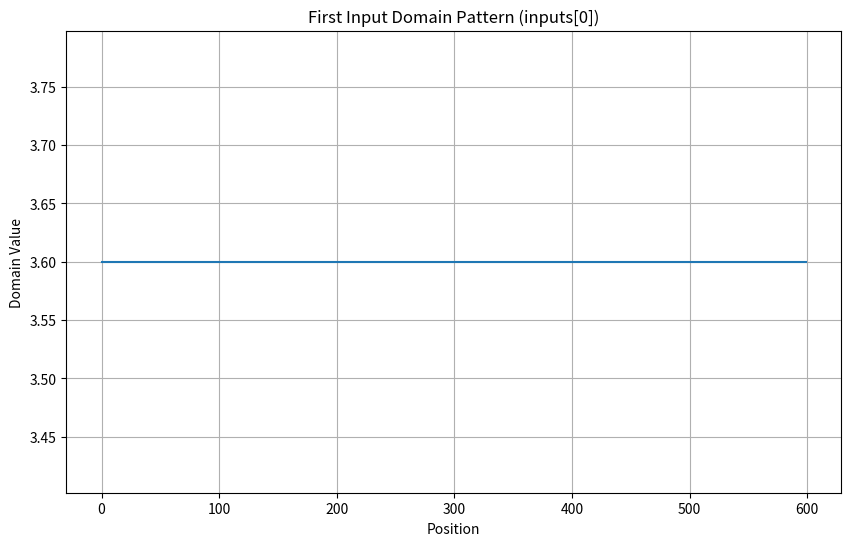

Elapsed time: 1.29 seconds


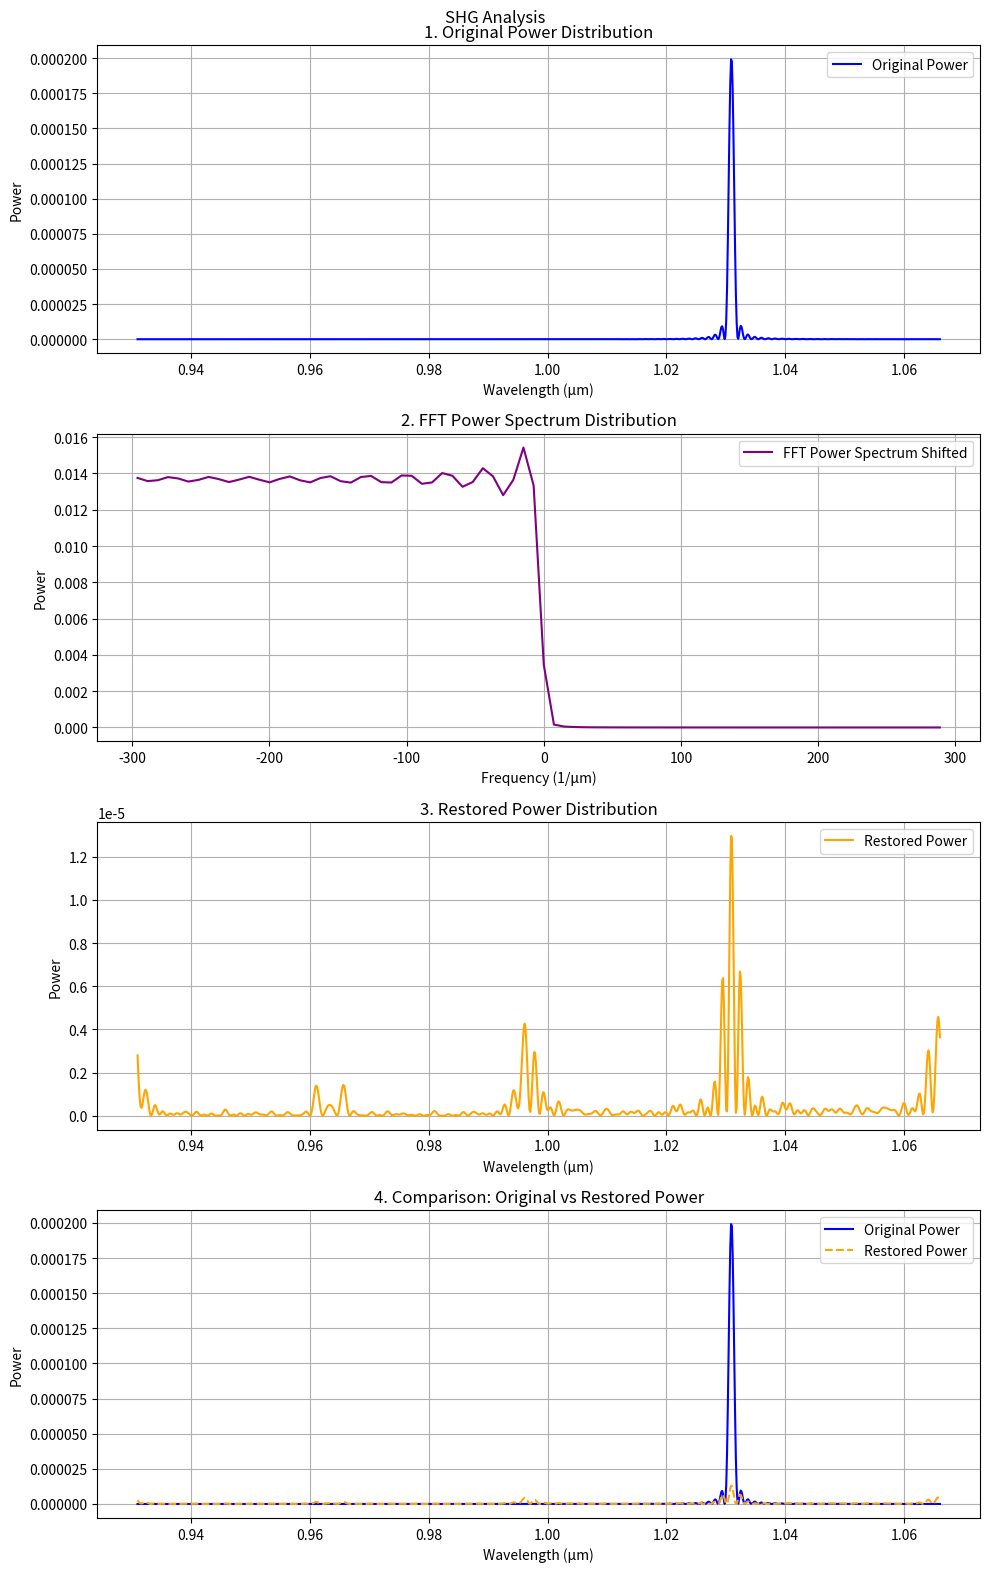

In [1]:
import jax.numpy as jnp
import timeit
import matplotlib.pyplot as plt
from syuron import shg, mgoslt, pp

# なんか級数展開しやすいドメイン数というのがある気がする
chirped_grating = pp.chirped(600, [3.6], 1.031E-05, [0.0001])
fixed_grating = pp.fixed(600, [3.6], 1.031E-05)
random_grating = pp.random(1, 300, 1.031E-05, 3.4, 3.6)
grating = fixed_grating

# mesh の細かさが一定でも、対象とする波長範囲が狭くなるとフーリエ変換の成分の数が大幅に減ることには物理的な理由があるのかもしれない
# 指定の波長範囲の変換に寄与するドメインの数が減るからかもしれない
# いつもの chirped の図を書く時の波長範囲は0.931 ~ 1.066
wavelengths = jnp.linspace(0.931, 1.066, 1000).tolist()
delta_wavelength = wavelengths[1] - wavelengths[0]

params = shg.Params(
    grating_dim=grating,
    T_dim=70,
    wavelength_dim=wavelengths,
    fund_power_dim=1,
    sh_power_dim=0,
)

plt.figure(figsize=(10, 6))
print(grating.shape)
plt.plot(grating[0, :, 0])
plt.xlabel('Position')
plt.ylabel('Domain Value')
plt.title('First Input Domain Pattern (inputs[0])')
plt.grid(True)
plt.show()

start = timeit.default_timer()
eff_tensor = mgoslt.analyze(params)
stop = timeit.default_timer()
print(f"Elapsed time: {stop - start:.2f} seconds")
eff_complex = eff_tensor[3, 0, :, 0, 0]

original_power = jnp.abs(eff_complex)**2
fig, (ax_original, ax_fft, ax_restored,
      ax_comparison) = plt.subplots(4, 1, figsize=(10, 16))
fig.suptitle("SHG Analysis")

ax_original.plot(wavelengths, original_power,
                 color='blue', label="Original Power")
ax_original.set_xlabel("Wavelength (μm)")
ax_original.set_ylabel("Power")
ax_original.set_title("1. Original Power Distribution")
ax_original.legend()
ax_original.grid(True)


fft_result = jnp.fft.fft(eff_complex)
fft_power_spectrum = jnp.abs(fft_result)**2
freqs = jnp.fft.fftfreq(len(wavelengths), d=delta_wavelength)

# domainが300でnum_top_componentsが30の時一番いい感じにフィッティングできる
num_top_components = 30
sorted_indices = jnp.argsort(jnp.abs(fft_result))[::-1]
mask = jnp.zeros_like(fft_result)
mask = mask.at[sorted_indices[:num_top_components]].set(1.0)
fft_reduced = fft_result * mask

restored_complex = jnp.fft.ifft(fft_reduced)
restored_power = jnp.abs(restored_complex)**2

# FFT出力と周波数のシフト
freqs_shifted = jnp.fft.fftshift(freqs)
fft_power_spectrum_shifted = jnp.fft.fftshift(fft_power_spectrum)
fft_slice = slice(460, -460)
ax_fft.plot(freqs_shifted[fft_slice], fft_power_spectrum_shifted[fft_slice], color='purple',
            label="FFT Power Spectrum Shifted")
# ax_fft.plot(freqs, fft_power_spectrum, color='green',
#             label="FFT Power Spectrum")
ax_fft.set_xlabel("Frequency (1/μm)")
ax_fft.set_ylabel("Power")
ax_fft.set_title("2. FFT Power Spectrum Distribution")
ax_fft.legend()
ax_fft.grid(True)

ax_restored.plot(wavelengths, restored_power,
                 color='orange', label="Restored Power")
ax_restored.set_xlabel("Wavelength (μm)")
ax_restored.set_ylabel("Power")
ax_restored.set_title("3. Restored Power Distribution")
ax_restored.legend()
ax_restored.grid(True)

ax_comparison.plot(wavelengths, original_power,
                   color='blue', label="Original Power")
ax_comparison.plot(wavelengths, restored_power, color='orange',
                   linestyle='--', label="Restored Power")
ax_comparison.set_xlabel("Wavelength (μm)")
ax_comparison.set_ylabel("Power")
ax_comparison.set_title("4. Comparison: Original vs Restored Power")
ax_comparison.legend()
ax_comparison.grid(True)

fig.tight_layout()
plt.show()

In [ ]:
import pandas as pd


def export_to_csv():
    # 結果をDataFrameにまとめる
    # jax.numpy配列をnumpy配列に変換してからDataFrameに入れるのが確実
    df_results = pd.DataFrame({
        'wavelength': jnp.asarray(wavelengths),  # jax arrayをnumpy arrayに変換
        'efficiency': jnp.asarray(original_power)   # jax arrayをnumpy arrayに変換
    })

    # CSVファイルとして保存
    csv_filename = 'chirped_shg_efficiency.csv'
    df_results.to_csv(csv_filename, index=False, encoding='utf-8')
    print(f"SHG efficiency data saved to {csv_filename}")


export_to_csv()

SHG efficiency data saved to chirped_shg_efficiency.csv


データセットの入力の作成完了
計算が終了


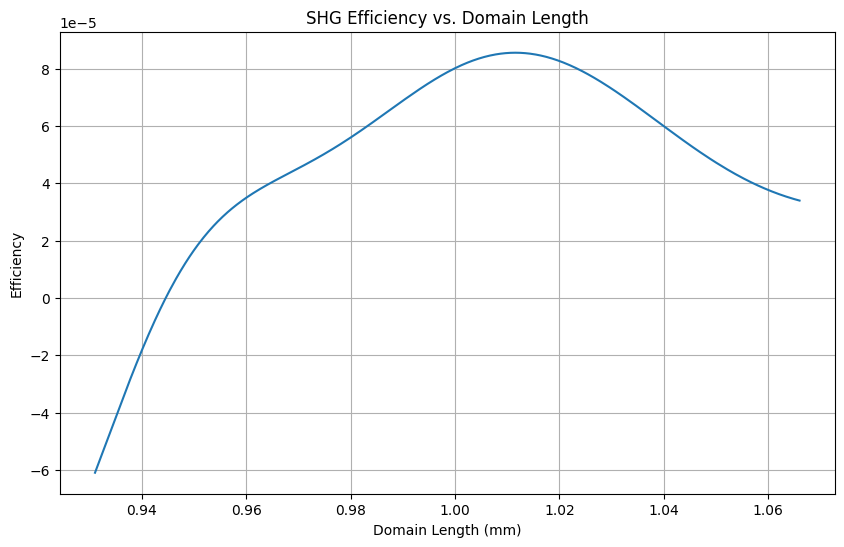

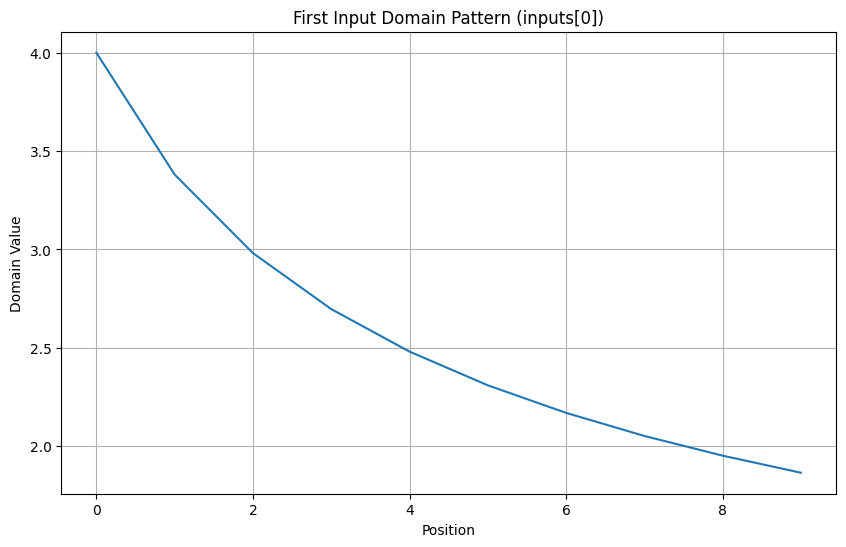

inputs shape: (100, 1000), outputs shape: (100, 10)


In [ ]:
from syuron import shg
import jax.numpy as jnp
from syuron import pp
from syuron import mgoslt
from workspace import path
import matplotlib.pyplot as plt
import tensorflow as tf

num_start_width = 10
num_chirp_rate = 10
num_domains = 10
num_samples = num_chirp_rate * num_start_width
chirped_grating = pp.chirped(num_domains, jnp.linspace(
    3, 4, num_start_width).tolist(), 1.031E-05, jnp.linspace(0.01, 0.05, num_chirp_rate).tolist())

print("データセットの入力の作成完了")

wavelength_dim = jnp.linspace(0.931, 1.066, 1000).tolist()

params = shg.Params(
    grating_dim=chirped_grating,
    T_dim=70,
    wavelength_dim=wavelength_dim,
    fund_power_dim=1,
    sh_power_dim=0,
    mesh_density=100
)

eff_tensor = mgoslt.analyze(params)

print("計算が終了")

example_index = 100

# 代表的なデータの可視化
example_eff = eff_tensor[example_index, 0, :, 0, 0].tolist()
plt.figure(figsize=(10, 6))
plt.plot(wavelength_dim, example_eff)
plt.xlabel('Domain Length (mm)')
plt.ylabel('Efficiency')
plt.title('SHG Efficiency vs. Domain Length')
plt.grid(True)
plt.show()


# 代表的なグレーティング周期の可視化
plt.figure(figsize=(10, 6))
# Plot the first input domain pattern
plt.plot(chirped_grating[example_index, :, 0])
plt.xlabel('Position')
plt.ylabel('Domain Value')
plt.title('First Input Domain Pattern (inputs[0])')
plt.grid(True)
plt.show()

eff_spectrums = eff_tensor[:, 0, :, 0, 0]
gratings = chirped_grating[:, :, 0]
print(
    f"inputs shape: {eff_spectrums.shape}, outputs shape: {gratings.shape}")

dataset = tf.data.Dataset.from_tensor_slices((eff_spectrums, gratings))
output_path = path.Path("research/syuron/dataset/chirped.tfrecord").abs()
# dataset.save(output_path)

2025-03-18 09:11:34.313556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742289094.339912   80206 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742289094.347884   80206 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742289094.367233   80206 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742289094.367255   80206 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742289094.367257   80206 computation_placer.cc:177] computation placer alr

データセットの入力の作成完了
計算が終了


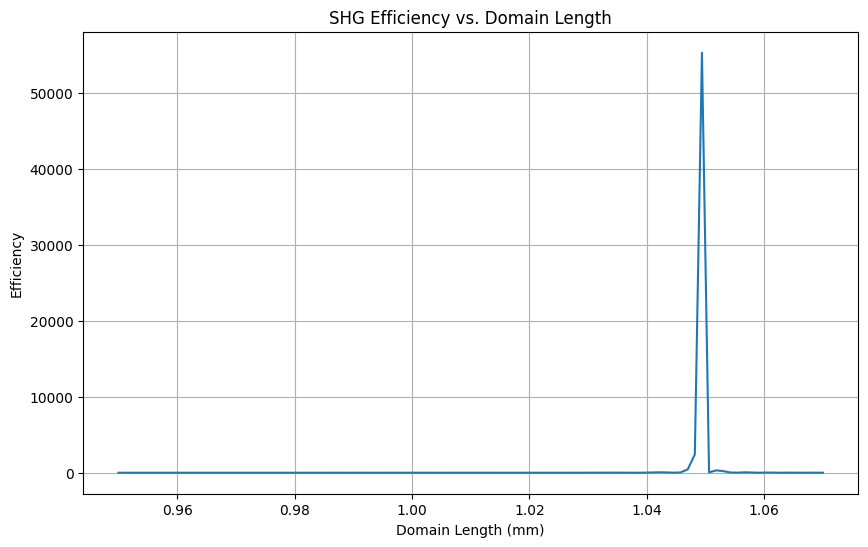

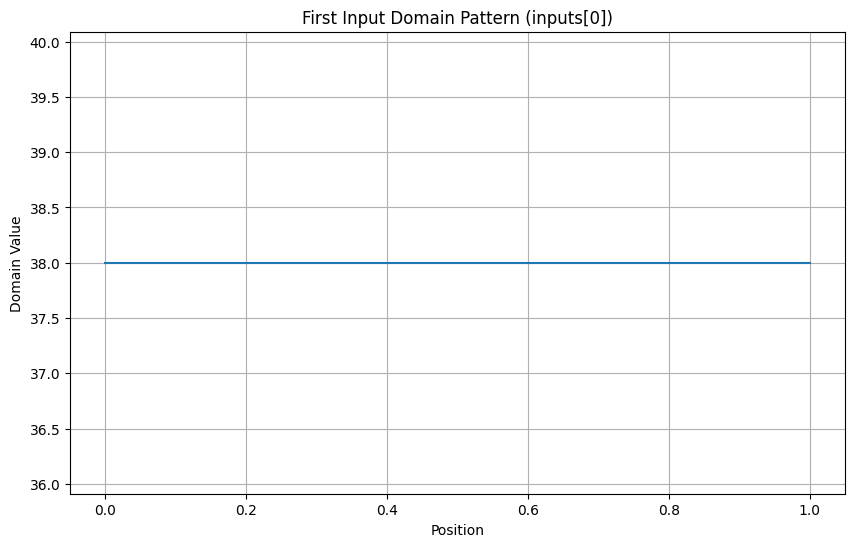

inputs shape: (10000, 100), outputs shape: (10000, 1000)
[(array([30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
     

In [ ]:
from syuron import shg
import jax.numpy as jnp
from syuron import pp
from syuron import mgoslt
from workspace import path
import matplotlib.pyplot as plt
import tensorflow as tf

num_samples = 10000
width_dim = jnp.linspace(3, 3.8, num_samples).tolist()
num_domains = 1000
chirped_grating = pp.fixed(num_domains, width_dim, 1.031E-05)

print("データセットの入力の作成完了")

wavelength_dim = jnp.linspace(0.95, 1.07, 100).tolist()

params = shg.Params(
    grating_dim=chirped_grating,
    T_dim=70,
    wavelength_dim=wavelength_dim,
    fund_power_dim=1,
    sh_power_dim=0,
    mesh_density=100
)

eff_tensor = mgoslt.analyze(params)

# 学習のために出力をスケーリング
eff_tensor = eff_tensor * 1e8
chirped_grating = chirped_grating * 10

print("計算が終了")

# example_index = 0
example_index = num_samples

# 代表的なデータの可視化
example_eff = eff_tensor[example_index, 0, :, 0, 0].tolist()
plt.figure(figsize=(10, 6))
plt.plot(wavelength_dim, example_eff)
plt.xlabel('Domain Length (mm)')
plt.ylabel('Efficiency')
plt.title('SHG Efficiency vs. Domain Length')
plt.grid(True)
plt.show()

# 代表的なグレーティング周期の可視化
example_domain = chirped_grating[example_index, :, 0]
x_axis = jnp.linspace(0, 1, num_domains).tolist()
plt.figure(figsize=(10, 6))
plt.plot(x_axis, example_domain)  # Plot the first input domain pattern
plt.xlabel('Position')
plt.ylabel('Domain Value')
plt.title('First Input Domain Pattern (inputs[0])')
plt.grid(True)
plt.show()

eff_spectrums = eff_tensor[:, 0, :, 0, 0]
gratings = chirped_grating[:, :, 0]
print(
    f"inputs shape: {eff_spectrums.shape}, outputs shape: {gratings.shape}")

# dataset = tf.data.Dataset.from_tensor_slices((eff_spectrums, gratings))
dataset = tf.data.Dataset.from_tensor_slices((gratings, eff_spectrums))
output_path = path.Path("research/syuron/dataset/fixed.tfrecord").abs()
# dataset.save(output_path)